In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# Import entire .csv file as a DataFrame
dataset = pd.read_csv('C:/data/ML_Models/RNN/IBM.csv',index_col='Date',parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


#### Column selection and dataset slicing
For this case "Close" stock price column is selected, which indicates IBM's closing price.

In [2]:
# Selecting column 'Close'
training_set = dataset[:'2016'].iloc[:,3:4].values
test_set = dataset['2017':].iloc[:,3:4].values

#### Apply Feature Scaling to the Data set
Used normalization technique for feature scaling using MinMaxscaler

In [3]:
# Scaling the training set
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

##### 'Close' attribute for prices visualization

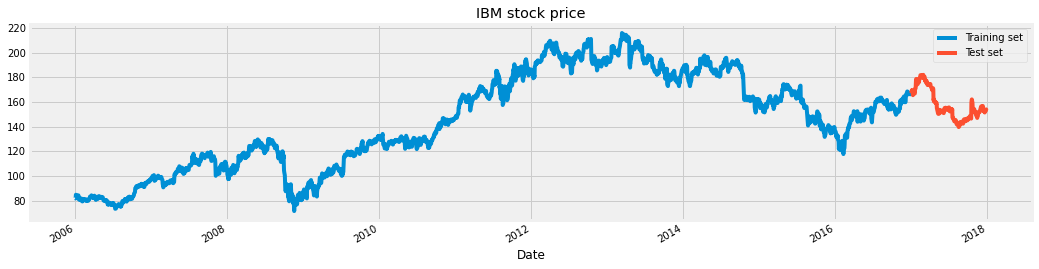

In [4]:
# 'Close' attribute for prices visualization.
dataset['Close'][:'2016'].plot(figsize=(16,4),legend=True)
dataset['Close']['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'] )
plt.title('IBM stock price')
plt.show()

#### Specify the Number of Timesteps
Timesteps specify how many previous observations should be considered when the recurrent neural network makes a prediction about the current observation. 
In this case, 60 timesteps is used, menaing for every day the neural network predicts, it will consider the previous 60 days of stock prices to determine its output.

In [5]:
# So for each element of training set, we have 60 previous training set elements 
X_train_data = []
y_train_data = []
for i in range(60,2769):
    # for i in range(60,len(training_set)):
    X_train_data.append(training_set_scaled[i-60:i,0])
    y_train_data.append(training_set_scaled[i,0])
    
# Transform to Numpy array
X_train_data, y_train_data = np.array(X_train_data), np.array(y_train_data)

# Reshaping X_train_data for efficient modelling
# Reason for reshaping is that the recurrent neural network layer only accepts data in a specific format
# Use np.reshape method
X_train_data = np.reshape(X_train_data, 
                          (X_train_data.shape[0],
                           X_train_data.shape[1],
                           1))

This outputs:

In [6]:
print(X_train_data.shape)

(2709, 60, 1)


### Building Recurrent Neural Network
### 1. Long Short Term Memory (LSTM)
Used Sequential class i.e. add sequences of layers over time to the build recurrent neural network.
##### Dropout Regularization
Dropout regularization is a technique used to avoid overfitting when training neural networks.

Epochs: the number of iterations for the recurrent neural network to be trained on. 

The batch size: the size of batches that the network will be trained in through each epoch.

Used Adam optimizer which is a workhorse optimizer that is useful in a wide variety of neural network architectures.

In [7]:
# Initialize recurrent neural network
rnn = Sequential()
# Add more layers to this recurrent neural network using the add method
# First LSTM layer with Dropout regularisation
rnn.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_data.shape[1],1)))
# Adding Some Dropout Regularization
# Dropout regularization is a technique used to avoid overfitting when training neural networks.
rnn.add(Dropout(0.2))

# Add Three more LSTM layer
# 2nd LSTM layer
rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.2))
# Third LSTM layer
rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.2))
# Fourth LSTM layer
rnn.add(LSTM(units=50))
rnn.add(Dropout(0.2))
# The output layer
rnn.add(Dense(units=1))
# Adding The Output Layer To Our Recurrent Neural Network
rnn.add(Dense(units=1))

# Compiling the RNN
# the compilation step of building a neural network is where we specify 
# the neural net’s optimizer and loss function
#rnn.compile(optimizer='rmsprop',loss='mean_squared_error') 
rnn.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy']) 
# The Adam optimizer is a workhorse optimizer that is useful in a wide variety of neural network architectures.
# Fitting the recurrent neural network on the training set
rnn.fit(X_train_data,y_train_data,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 11s 59ms/step - loss: 0.0230 - accuracy: 7.3828e-04
Epoch 2/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0052 - accuracy: 7.3828e-04
Epoch 3/50
85/85 [==============================] - 5s 64ms/step - loss: 0.0044 - accuracy: 7.3828e-04
Epoch 4/50
85/85 [==============================] - 6s 65ms/step - loss: 0.0044 - accuracy: 7.3828e-04
Epoch 5/50
85/85 [==============================] - 5s 65ms/step - loss: 0.0045 - accuracy: 7.3828e-04
Epoch 6/50
85/85 [==============================] - 6s 69ms/step - loss: 0.0036 - accuracy: 7.3828e-04
Epoch 7/50
85/85 [==============================] - 5s 64ms/step - loss: 0.0034 - accuracy: 7.3828e-04
Epoch 8/50
85/85 [==============================] - 5s 64ms/step - loss: 0.0034 - accuracy: 7.3828e-04
Epoch 9/50
85/85 [==============================] - 6s 66ms/step - loss: 0.0031 - accuracy: 7.3828e-04
Epoch 10/50
85/85 [==============================] - 5s 64ms/step - loss

#### Building The Test Data Set
Create an array to hold stock prices from Jan 2017 and the 60 trading days prior to January 2017

In [8]:
# Preparing the dataset
# Used the first 60 entires of test set
dataset_total = pd.concat((dataset["Close"][:'2016'],dataset["Close"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1) # To make it suitable for predict method
inputs  = sc.transform(inputs)


#### Making Predictions
Used the test data set to make predictions by calling the predict method on the rnn object.

In [9]:
# Grouping the Test Data
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# making predictions
predicted_stock_price = rnn.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#print(predicted_stock_price.shape)

8/8 [==============================] - 2s 23ms/step


In [10]:
X_test

array([[[0.59100375],
        [0.58260447],
        [0.59197557],
        ...,
        [0.6556296 ],
        [0.65847564],
        [0.65424129]],

       [[0.58260447],
        [0.59197557],
        [0.5764959 ],
        ...,
        [0.65847564],
        [0.65424129],
        [0.66257115]],

       [[0.59197557],
        [0.5764959 ],
        [0.57302513],
        ...,
        [0.65424129],
        [0.66257115],
        [0.67694016]],

       ...,

       [[0.52006109],
        [0.52089407],
        [0.51881161],
        ...,
        [0.5536582 ],
        [0.56059975],
        [0.56289046]],

       [[0.52089407],
        [0.51881161],
        [0.52047758],
        ...,
        [0.56059975],
        [0.56289046],
        [0.56497293]],

       [[0.51881161],
        [0.52047758],
        [0.51881161],
        ...,
        [0.56289046],
        [0.56497293],
        [0.57128974]]])

#### Plot the Predictions
The plot compares the predicted stock prices with IBM's actual stock price.

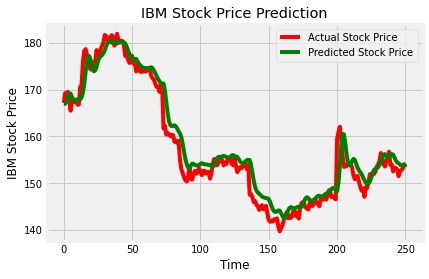

In [11]:
plt.plot(test_set, color='red',label='Actual Stock Price')
plt.plot(predicted_stock_price, color='green',label='Predicted Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()


#### Evaluating the Model
Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data.

In [12]:
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 2.7064072331579374.


The lower the RMSE, the better a given model is able to "fit" a dataset

With a rmse of 2.4, the model is doing well.

### 2. Gated Recurrent Units (GRU)
GRU is similar to LSTM, but it has fewer gates. Also, it relies solely on a hidden state for memory transfer between recurrent units, so there is no separate cell state.
#### Adding Layers to GRU RNN 
The GRU RNN is a Sequential Keras model. After initializing the Sequential model, there's need to add in the layers. The first layer to add is the Gated Recurrent Unit layer.

In [13]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_data.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_data.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train_data.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error',metrics=['accuracy'])
# Fitting to the training set
regressorGRU.fit(X_train_data,y_train_data,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 11s 210ms/step - loss: 0.1093 - accuracy: 3.6914e-04
Epoch 2/50
19/19 [==============================] - 4s 227ms/step - loss: 0.0382 - accuracy: 7.3828e-04
Epoch 3/50
19/19 [==============================] - 5s 237ms/step - loss: 0.0107 - accuracy: 7.3828e-04
Epoch 4/50
19/19 [==============================] - 4s 234ms/step - loss: 0.0050 - accuracy: 7.3828e-04
Epoch 5/50
19/19 [==============================] - 5s 242ms/step - loss: 0.0043 - accuracy: 7.3828e-04
Epoch 6/50
19/19 [==============================] - 5s 241ms/step - loss: 0.0040 - accuracy: 7.3828e-04
Epoch 7/50
19/19 [==============================] - 5s 277ms/step - loss: 0.0037 - accuracy: 7.3828e-04
Epoch 8/50
19/19 [==============================] - 4s 237ms/step - loss: 0.0036 - accuracy: 7.3828e-04
Epoch 9/50
19/19 [==============================] - 4s 227ms/step - loss: 0.0035 - accuracy: 7.3828e-04
Epoch 10/50
19/19 [==============================] - 4s 223ms/s

Used the same dataset to train the GRU model. To train the model in Keras, we just call the fit function.

#### Test the GRU Model
Used the same test data set that was used to predict in the LSTM model.

In [14]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 1s 17ms/step


#### Predictions Visualization
In this case we visualize the predicted values and the actual stock pricce.

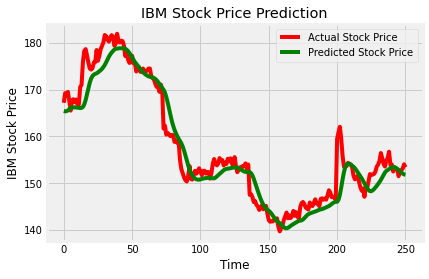

In [15]:
plt.plot(test_set, color='red',label='Actual Stock Price')
plt.plot(GRU_predicted_stock_price, color='green',label='Predicted Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

#### Evaluating the Model
Root Mean Square Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data.

The lower the RMSE, the better a given model is able to "fit" a dataset.

In [16]:
rmse = math.sqrt(mean_squared_error(test_set, GRU_predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 3.3492268696245144.


#### Interpretation
From the visualization above, after 50 epochs, the model does quite well for both the training and validation data. It predicts the pattern correctly.

In [19]:
#import pickle
# open a file where to store the data
#file=open('lstm_gru_model.pkl','wb')

# dump information to that file
#pickle.dump(rnn, file)
rnn.save('lstm_model.h5')

In [18]:
# Loading model to compare results